# Working with geolocation data


In this practical, we will look at the location data we have stored for each tweet.  We will learn how to process geolocation coordinates, and obtain a more human readable label for these locations by obtaining full address information such as town, city, and county names, which we will be using to summarise and visualise the tweets.

Our first task this week is to load our data set and beginning exploring the locations referenced in the Twitter data set.  We import the Pandas library as before, read in the .csv file, and call .head(20) on the data frame to view the first 20 rows of data:

In [21]:
import pandas as pd

df = pd.read_csv('https://raw.githubusercontent.com/BBKdatasciencetaster/DS/main/data/twitter_data_olio_UK_b.csv')
df.head()

,date,_id,place_name,place_type,lat,lng,text
0,Tue Sep 29 20:57:35 +0000 2020,1311047494021701632,Oadby,city,52.5883,-1.09612,"""Hovis granary wholemeal"" in #Leicester #Unite..."
1,Tue Sep 29 20:43:53 +0000 2020,1311044046471585792,Oadby,city,52.5883,-1.09612,"""Celery"" in #Leicester #UnitedKingdom https://..."
2,Tue Sep 29 20:43:26 +0000 2020,1311043935322611712,Hammersmith,city,51.4865,-0.22651,"""Eat 17 - small baguettes"" in #London #UnitedK..."
3,Tue Sep 29 20:41:30 +0000 2020,1311043448972083203,Barking,city,51.5409,0.12200,"""Salad"" in #Dagenham #UnitedKingdom https://t...."
4,Tue Sep 29 20:41:06 +0000 2020,1311043346257772544,Glasgow,city,55.8720,-4.26896,"""Humous and Chipotle Wrap"" in #Glasgow #United..."


The next step is to look at summary statistics computed over the whole dataset, the .describe() method produces a simple report on the number of rows of data, the number of unique items we have, and the most common category together with its count. 

In [22]:
df['place_name'].describe()

count         4634
unique         289
top       East Ham
freq           241
Name: place_name, dtype: object

From running the example, we see that the dataset contains 4,634 unique tweets, with 289 unique locations mentioned across the United Kingdom. Of the total tweets the most mentioned location is 'East Ham' with 241 tweets.  To learn more about the whole data set, we can summarise the values of our columns. We will first explore the locations that are mentioned with the tweets, by grouping the data according to the locations stored under the 'place_name' column. We then select the top-10 rows with the highest frequency counts as our summary:

In [23]:
place_names = df.groupby(['place_name']).size().nlargest(10)
place_names

place_name
East Ham       241
Walthamstow    226
Richmond       188
Reading        176
Hull           148
Islington      145
Stevenage      129
Grays          114
Ipswich        108
Poplar         108
dtype: int64

Let's visualise these summary statistics to get a feel for the proportion of tweets mentioning each location. We plot our summary as a simple bar chart, and add a title and y-axis label:

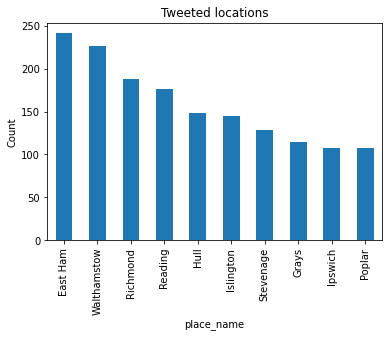

In [24]:
barchart = place_names.plot(kind='bar')
barchart.set_title('Tweeted locations')
barchart.set_ylabel('Count')
barchart

Another column we can inspect is the 'place_type', which will tell us the types of locations mentioned, such as 'city'. Calling the .size() method on the grouped data will return the number of rows per categ

In [25]:
df.groupby(['place_type']).size()

place_type
admin      83
city     4551
dtype: int64

The majority of our data set contains locations relating to cities. However, a small proportion of our data (83 rows in total) are described by the Twitter API as 'admin'.  Let's explore this further to see what this means by selecting the subset of our data where the 'place_type' is equal to 'admin'. We will select a random sample of 20 rows from this subset to act as our summary:

In [26]:
df.loc[df['place_type'] == 'admin'].sample(10)

,date,_id,place_name,place_type,lat,lng,text
465,Tue Sep 29 16:26:28 +0000 2020,1310979266604142592,London,admin,51.671963,-0.016852,"""Bacon roll "" in #Enfield #UnitedKingdom https..."
2596,Mon Sep 28 07:51:17 +0000 2020,1310487229727420418,East,admin,52.604352,1.172783,"""5 donuts "" in #Norwich #UnitedKingdom https:/..."
3405,Thu Oct 01 07:51:06 +0000 2020,1311574343919579138,South East,admin,51.454500,-0.856300,"""Warburton Toasties "" in #Reading #UnitedKing..."
958,Tue Sep 29 10:23:28 +0000 2020,1310887915006963712,South East,admin,51.600200,-1.263760,"""Thick white toastie loaf 800g "" in #Didcot #U..."
3359,Thu Oct 01 08:12:08 +0000 2020,1311579639161200645,West Midlands,admin,52.366900,-1.701310,"""Tiger rolls 6pack "" in #Solihull #UnitedKingd..."
3386,Thu Oct 01 07:58:46 +0000 2020,1311576274754732032,South East,admin,51.454500,-0.856300,"""2 Plain croissants"" in #Reading #UnitedKingdo..."
1070,Tue Sep 29 09:35:07 +0000 2020,1310875745548472320,Bailiwick of Jersey,admin,49.201000,-2.143830,"""Aubergine"" in #Jersey #UnitedKingdom https://..."
2595,Mon Sep 28 07:52:31 +0000 2020,1310487539543875584,East,admin,52.604352,1.172783,"""5 sweet pastries"" in #Norwich #UnitedKingdom ..."
2593,Mon Sep 28 07:53:38 +0000 2020,1310487820474212352,East,admin,52.604352,1.172783,"""Sweet pastries "" in #Norwich #UnitedKingdom h..."
1019,Tue Sep 29 10:00:44 +0000 2020,1310882194618044416,South East,admin,51.600193,-1.263759,"""Fair trade bananas "" in #Didcot #UnitedKingdo..."


From the summary we observe that the place type 'admin' appears to be assigned to large regions, in other words, the location encoded by the tweet relates to an administrative district rather than a city, despite the presence of hashtags relating to the city name in the tweet text, e.g. #Falkirk, #Didcot, and #Enfield. Before we continue we will correct the place name for these tweets so that they refer to the city rather than the level of administrative district.

How might we correct these values?  If we think about the information we have about each tweet, can you think of a method to retrieve the correct city name? We will correct this issue by extracting the missing values using another API that will identify a location and the full address given coordinates in the form of latitude and longitude, by applying a method known as reverse geo-coding. Given a set of coordinates, reverse geo-coding involves extracting a text string with address information that we can use to fill in our missing data. We will extract the town or city name for the locations listed as "admin" using the geo-coordinates latitude and longitude stored in the tweet.  

To do this we will import another Python library called geopy, which will take these and return a full address. You can learn more about using the geopy library by reading the official documentation (https://geopy.readthedocs.io/en/latest/). 

First, let's see how this works in practice. We first import the necessary tools and define a random name for our application, which will be used by the API to identify our request. This identifier can be any text string you can think of.  

Once the library is imported, we create a 'geolocator' object, which has a 'reverse' method where we pass the latitude and longitude coordinates. This method returns address details about the location, which we will store in a variable called 'location': 

In [27]:
# reverse geocoding
from geopy.geocoders import Nominatim

app_name = "my awesome app" # <- necessary to identify your request and access the geopy API.

geolocator = Nominatim(user_agent=app_name)

coordinates = '51.52194, -0.13032'

location = geolocator.reverse(coordinates)

We can now inspect the data returned by the method call. To view a text string of the full address, we can view the .address attribute:

In [28]:
# Retrieving the full address string:
location.address

'Birkbeck, University of London, Torrington Square, St Giles, Bloomsbury, London Borough of Camden, London, Greater London, England, WC1E 7JL, United Kingdom'

We can also obtain a more useful representation that we can use to extract specific values from the address.  The returned location data also has a 'raw' attribute containing a JSON representation of the address and additional metadata:

In [ ]:
# Retrieving a JSON object for querying specific attributes
location.raw

{'address': {'amenity': 'Birkbeck, University of London',
  'city': 'London',
  'city_district': 'London Borough of Camden',
  'country': 'United Kingdom',
  'country_code': 'gb',
  'neighbourhood': 'St Giles',
  'postcode': 'WC1E 7JL',
  'road': 'Torrington Square',
  'state': 'England',
  'state_district': 'Greater London',
  'suburb': 'Bloomsbury'},
 'boundingbox': ['51.5214844', '51.5232251', '-0.131087', '-0.1295004'],
 'display_name': 'Birkbeck, University of London, Torrington Square, St Giles, Bloomsbury, London Borough of Camden, London, Greater London, England, WC1E 7JL, United Kingdom',
 'lat': '51.5220712',
 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. https://osm.org/copyright',
 'lon': '-0.1304649335480022',
 'osm_id': 11943583,
 'osm_type': 'relation',
 'place_id': 283737894}

## Task: Locate yourself

As we can see, the .address attribute stores the address according to various fields, such as 'road', 'suburb', and 'city', which means we have all the information we need to address the issue of missing or incorrect values.  Let's check the address information for your current location.  First, visit <a src="https://mylocation.org/">mylocation.org</a> and make a note of the latitute and longitude coordinates. Paste these together and assign them to the 'coordinates' variable.  When you run the example again, you should see the full address of your current location.

In [30]:
# reverse geocoding
from geopy.geocoders import Nominatim

app_name = "my awesome app" # <- necessary to identify your request and access the geopy API.

geolocator = Nominatim(user_agent=app_name)

coordinates = '51.52194, -0.13032' # <- paste your coordinates here
try:
    location = geolocator.reverse(coordinates)
    location
except: print("Don't forget, your coordinates should be formatted to look like this '3.0000,50.0000' ")

Now let's return to the issue we wish to address, that is we want to extract the county name for areas defined as administrative ('admin'). One cavaet is that not all the missing values are of the type 'city', some locations maybe 'suburbs', or 'villages', so we need to capture this in our code to ensure that we fill in all the missing data correctly.  We first load the data we processed earlier, then proceed to iterate through each row and pull out the relevant values based on the conditions we have set, as follows:

In [31]:
print("Reverse geo-coding in progress, this may take a minute...")

# Import the reverse geocoding python library
from geopy.geocoders import Nominatim

# necessary to identify your request and gain access to the geopy API.
app_name = "my awesome app"

geolocator = Nominatim(user_agent=app_name)

for idx, lat, lng, place_type, text in zip(df.index, df.lat, df.lng, df.place_type, df.text):
    # skip all rows if the place_type is different from admin.
    if place_type != 'admin': continue 
        
    location = geolocator.reverse("%s, %s" %(lat, lng))
    address = location.raw['address']
    
    # Check to see if there is a 'city' attribute we can access.
    place_name = address.get('city', None)
    place_type = 'city' # <- we will assume a default place type of city.
    
    if place_name == None:
        # No city attribute, check to see if there is a 'suburb' attribute we can access.
        place_name = address.get('suburb', None) 
        place_type = 'suburb'
        
    if place_name == None:
        # No city or suburb attribute, check to see if there is a 'hamlet' attribute we can access.
        place_name = address.get('hamlet', None) 
        place_type = 'hamlet'   
        
    if place_name == None: 
        # No city, suburb, or hamlet attribute, check to see if there is a 'town' attribute we can access.
        place_name = address.get('town', None) 
        place_type = 'town'
        
    if place_name == None: 
        # None of the above, check to see if there is a 'village' attribute we can access.
        place_name = address.get('village', None)
        place_type = 'village'
    
    df.loc[idx, 'place_name'] = place_name
    df.loc[idx, 'place_type'] = place_type

    #print([idx], (lat, lng), place_name, place_type)
print ("All done!")

Reverse geo-coding in progress, this may take a minute...
All done!


Once complete, we can now inspect the unique values stored in the place_types column to verify that all rows with a place type of 'admin' have been replaced with more specific information:

In [32]:
df['place_type'].unique()

array(['city', 'village', 'suburb', 'hamlet'], dtype=object)

As we can see all of the locations listed as 'admin' by the Twitter API, have now been corrected using information we have gathered through reverse geo-coding.